In [206]:
import cv2
import rasterio
import numpy as np
from PIL import Image
from tqdm.auto import tqdm
import math
from pathlib import Path
import albumentations as A
from rasterio.plot import reshape_as_image
from torch.utils.data import Dataset
from torchvision import transforms

class SegmentDataset(Dataset):
    def __init__(self, 
                 image_path: Path, 
                 mask_path: Path, 
                 patch_size: int,
                 transform: A.Compose = None,
                 save = False,
                 path_to_save = None):
        super().__init__()
        self.image_path = image_path
        self.mask_path = mask_path
        self.patch_size = patch_size
        self.transform = transform
        self.save_images = save_images
        self.path_to_save = path_to_save
 
        with rasterio.open(self.image_path, 'r', driver='JP2OpenJPEG') as src:
                self.image_raster = src.read()

        with rasterio.open(self.mask_path, 'r', driver='JP2OpenJPEG') as src:
                self.mask_raster = src.read()

        if self.image_raster[0].shape == self.mask_raster[0].shape:
            self.width = self.image_raster.shape[1]
            self.height = self.image_raster.shape[2]

            self.images = self.make_patches(self.image_raster)
            self.masks = self.make_patches(self.mask_raster)
        
        if self.save_images:
            self.save_patches()
            
    def make_patches(self, raster: np.array): 
        slices = []    
        for h_cord in np.arange(start=self.patch_size, 
                                stop=self.height + 1, 
                                step=self.patch_size):
            for w_cord in np.arange(start=self.patch_size, 
                                    stop=self.width + 1, 
                                    step=self.patch_size):
                slices.append(reshape_as_image(raster[:, 
                                     h_cord - self.patch_size: h_cord, 
                                     w_cord - self.patch_size: w_cord]))
        return slices
    
    def save_patches(self):
        if self.patch_size is None:
            raise ValueError('You must specify patch size.')
        tqd = tqdm(enumerate(zip(self.images, self.masks), start = 1))
        
        for i, (image, mask) in tqd:
            parent = Path(self.path_to_save) / str(self.patch_size)
            img_path = parent / 'images'
            mask_path = parent / 'masks'
            
            img_path.mkdir(exist_ok=True, parents=True)
            mask_path.mkdir(exist_ok=True, parents=True)
            
            cv2.imwrite(str(img_path / f'{i}.jpg'), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
            cv2.imwrite(str(mask_path / f'{i}.jpg'), mask)
            
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]
        
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
        return image, mask

In [207]:
args = {
    'image_path': 'data/raw/image.jp2',
    'mask_path': 'data/raw/mask.jp2',
    'patch_size': 256,
    'path_to_save': 'data',
    'save_images': False,
    'mean_std_path': 'data/cashe/mean_std.pth',
    'test_ratio' : 0.2
}

In [210]:
def get_mean_std(args):
    p = Path(args['mean_std_path'])
    if p.exists():
        file = torch.load(p)
        print('Mean and std loaded from cashe.')
        return file['mean'], file['std']

    ds = SegmentDataset(image_path = args['image_path'], 
                        mask_path = args['mask_path'], 
                        patch_size = args['patch_size'],
                        transform = ToTensorV2())

    dl = DataLoader(ds, batch_size=len(ds), shuffle=False, num_workers=0)

    images, _ = next(iter(dl))
    images = images / 255
    # shape of images = [b,c,w,h]
    mean, std = images.mean([0, 2, 3]), images.std([0, 2, 3])
    return mean, std

def get_transform(train, args):
    trans = []
    if train:
        trans.extend([])
        
    trans.extend([
        A.Normalize(*get_mean_std(args)),
        ToTensorV2()
    ])
    trans = A.Compose(trans)
    return trans


def get_sampler(train_len, args):
    indices = torch.randperm(train_len)

    # Count limit number for train and val ids
    split = int(math.ceil(val_ratio * train_len))
    train_idx, val_idx = indices[split:], indices[:split]

    # Create sampler for given ids
    train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)

In [168]:
def get_dataset(args):
    train_dataset = SegmentDataset(image_path = args['image_path'], 
                         mask_path = args['mask_path'], 
                         patch_size = args['patch_size'],
                         transform = get_transform(True, args),
                         path_to_save = args['path_to_save'], 
                         save = args['save'])
    
    test_dataset = SegmentDataset(image_path = args['image_path'], 
                         mask_path = args['mask_path'], 
                         patch_size = args['patch_size'],
                         transform = get_transform(False, args),
                         path_to_save = args['path_to_save'], 
                         save = args['save'])
    
    return train_dataset

In [169]:
ds = get_dataset(args)

In [171]:
it = iter(ds)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


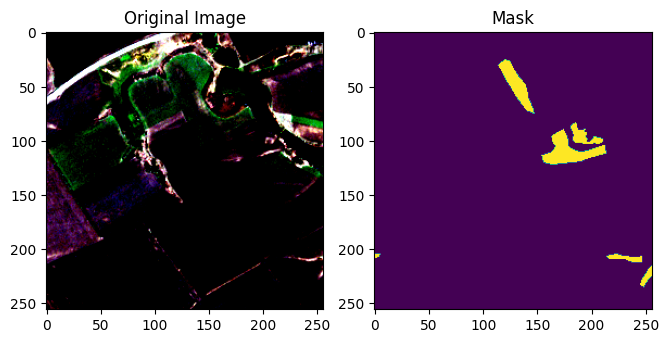

In [205]:
import matplotlib.pyplot as plt
# create a new figure
fig = plt.figure(figsize=(10, 5))
org, mask = next(it)

# add the original image subplot to the figure
ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(org.permute(1, 2, 0))
ax1.set_title('Original Image')

# add the mask subplot to the figure
ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(mask)
ax2.set_title('Mask')

# adjust the spacing between subplots
fig.tight_layout()

# show the figure
plt.show()